In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Import thư viện

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Model
import xgboost as xgb
from xgboost import plot_importance, plot_tree

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU

from statsmodels.tsa.arima.model import ARIMA

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

# Data

In [23]:
df = pd.read_csv("/content/drive/MyDrive/IS403/Project/Data/AMZN.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Data//AMZN.csv'

In [ ]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,73.260002,77.667999,73.046501,76.956497,76.956497,159662000
1,2019-01-03,76.000504,76.900002,74.855499,75.014000,75.014000,139512000
2,2019-01-04,76.500000,79.699997,75.915497,78.769501,78.769501,183652000
3,2019-01-07,80.115501,81.727997,79.459503,81.475502,81.475502,159864000
4,2019-01-08,83.234497,83.830498,80.830498,82.829002,82.829002,177628000
...,...,...,...,...,...,...,...
1059,2023-03-17,99.790001,100.660004,97.459999,98.949997,98.949997,87173200
1060,2023-03-20,98.410004,98.480003,95.699997,97.709999,97.709999,62388900
1061,2023-03-21,98.139999,100.849998,98.000000,100.610001,100.610001,58597300
1062,2023-03-22,100.449997,102.099998,98.610001,98.699997,98.699997,57475400


# Preprocessing

## Check null and na value

In [ ]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
df.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

## Checking datatype of each column

In [ ]:
print("Date column data type: ", type(df['Date'][0]))
print("Open column data type: ", type(df['Open'][0]))
print("Close column data type: ", type(df['Close'][0]))
print("High column data type: ", type(df['High'][0]))
print("Low column data type: ", type(df['Low'][0]))
print("Adj Close column data type: ", type(df['Adj Close'][0]))
print("Volume column data type: ", type(df['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


## Convert date from string to date format

In [ ]:
df['Date'] = pd.to_datetime(df.Date)

# EDA - Exploratory Data Analysis

## Get the duration of dataset

In [ ]:
print("Starting date: ",df.iloc[0][0])
print("Ending date: ", df.iloc[-1][0])
print("Duration: ", df.iloc[-1][0]-df.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2023-03-23 00:00:00
Duration:  1541 days 00:00:00


## OHLC Chart

#### An OHLC chart shows the open, high, low and close prices of a stock. It shows you how the price was changing during a particular day and give you a sense of e.g. momentum or volatility of stock. The tip of the lines represent the low and high values and the horizontal segments represent the open and close values. Sample points where the close value is higher (lower) then the open value are called increasing (decreasing). By default, increasing items are drawn in green whereas decreasing are drawn in red.(Một biểu đồ OHLC cho thấy giá mở, cao, thấp và đóng của cổ phiếu. Nó cho bạn thấy giá thay đổi như thế nào trong một ngày cụ thể)

In [ ]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

# Technical indicators

#### Moving Averages (MA) help to smooth out stock prices on a chart by filtering out short-term price fluctuations. We calculate moving averages over a defined period of time e.g. last 9, 50 or 200 days. There are two (most common) averages used in technical analysis which are:

*   Simple Moving Average (SMA) - a simple average calculated over last N days e.g. 50, 100 or 200.
*   Exponential Moving Average (EMA) - an average where greater weights are applied to recent prices.


In [ ]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30
0,2019-01-02,73.260002,77.667999,73.046501,76.956497,76.956497,159662000,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,76.000504,76.900002,74.855499,75.014000,75.014000,139512000,76.956497,NaN,NaN,NaN,NaN
2,2019-01-04,76.500000,79.699997,75.915497,78.769501,78.769501,183652000,75.934130,NaN,NaN,NaN,NaN
3,2019-01-07,80.115501,81.727997,79.459503,81.475502,81.475502,159864000,76.980392,NaN,NaN,NaN,NaN
4,2019-01-08,83.234497,83.830498,80.830498,82.829002,82.829002,177628000,78.287490,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2023-03-17,99.790001,100.660004,97.459999,98.949997,98.949997,87173200,95.161650,94.856000,94.265000,93.896000,96.895667
1060,2023-03-20,98.410004,98.480003,95.699997,97.709999,97.709999,62388900,95.540485,96.499998,94.670000,94.259333,96.430333
1061,2023-03-21,98.139999,100.849998,98.000000,100.610001,100.610001,58597300,95.757436,97.555998,95.066000,94.522666,96.241000
1062,2023-03-22,100.449997,102.099998,98.610001,98.699997,98.699997,57475400,96.242693,98.701999,95.771999,94.948000,96.188667


## Relative Strength Index

#### Relative Strength Index (RSI) that indicates magnitude of recent price changes. It can show that a stock is either overbought or oversold. Typically RSI value of 70 and above signal that a stock is becoming overbought/overvalued, meanwhile value of 30 and less can mean that it is oversold. Full range of RSI is from 0 to 100.

In [ ]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

## MACD

#### Moving Average Convergence Divergence (MACD) is an indicator which shows the relationship between two exponential moving averages i.e. 12-day and 26-day EMAs. We obtain MACD by substracting 26-day EMA (also called slow EMA) from the 12-day EMA (or fast EMA).

In [ ]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

## Shift label column

In [ ]:
df['Close'] = df['Close'].shift(-1)

## Drop invalid samples

In [ ]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

# Train, Valid, Test

In [ ]:
test_size  = 0.1
valid_size = 0.2

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

## Drop unnecessary columns

In [ ]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High','Adj Close']

train_df = train_df.drop(drop_cols,1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

<ipython-input-17-4717bc36458f>:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

<ipython-input-17-4717bc36458f>:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

<ipython-input-17-4717bc36458f>:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



## Split into features and labels

In [ ]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        722 non-null    float64
 1   SMA_5        722 non-null    float64
 2   SMA_10       722 non-null    float64
 3   SMA_15       722 non-null    float64
 4   SMA_30       722 non-null    float64
 5   RSI          722 non-null    float64
 6   MACD         722 non-null    float64
 7   MACD_signal  722 non-null    float64
dtypes: float64(8)
memory usage: 45.2 KB


<ipython-input-18-ded38c391784>:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

<ipython-input-18-ded38c391784>:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

<ipython-input-18-ded38c391784>:8: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



# Visualize

In [ ]:
def visualize(data, y_pred, y_test):
  predicted_prices = df.loc[test_split_idx+1:].copy()
  predicted_prices['Close'] = y_pred

  fig = make_subplots(rows=2, cols=1)
  fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                          name='Truth',
                          marker_color='LightSkyBlue'), row=1, col=1)

  fig.add_trace(go.Scatter(x=predicted_prices.Date,
                          y=predicted_prices.Close,
                          name='Prediction',
                          marker_color='MediumPurple'), row=1, col=1)

  fig.add_trace(go.Scatter(x=predicted_prices.Date,
                          y=y_test,
                          name='Truth',
                          marker_color='LightSkyBlue',
                          showlegend=False), row=2, col=1)

  fig.add_trace(go.Scatter(x=predicted_prices.Date,
                          y=y_pred,
                          name='Prediction',
                          marker_color='MediumPurple',
                          showlegend=False), row=2, col=1)

  fig.show()

# Evaluation

In [ ]:
def evaluation(y_test, y_pred):
  print(f'MSE = {mean_squared_error(y_test, y_pred)}')
  print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')
  print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
  print(f'R2_Score = {r2_score(y_test, y_pred)}')
  print(f'MAPE = {mean_absolute_percentage_error(y_test, y_pred)}')

# XGBOOST

## Fine-tune

In [ ]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[07:38:49] WARNING: ../src/lea

## Model

In [ ]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
y_pred_xgb = model.predict(X_test)

## Evaluation

In [ ]:
evaluation(y_test, y_pred_xgb)

MSE = 21.408020428172378
RMSE = 4.626880204648957
MAE = 3.4341968739133355
R2_Score = 0.4519383321262771
MAPE = 0.03619652865850237


## Visualize predictions

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

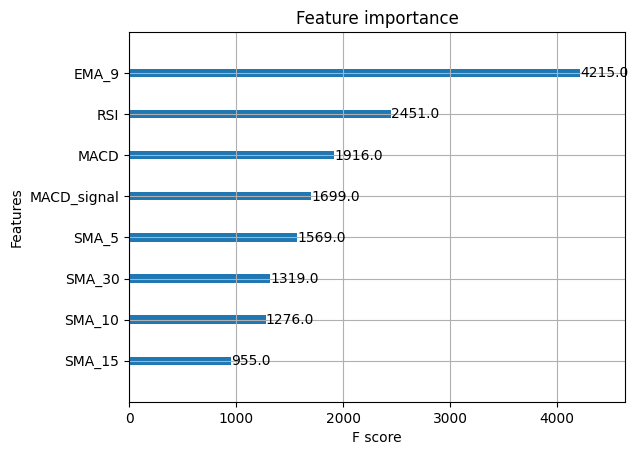

In [ ]:
plot_importance(model)

In [ ]:
visualize(df, y_pred_xgb, y_test)

# SVR

## Model

In [ ]:
svr_rbf = SVR(kernel= 'rbf')
svr_rbf.fit(X_train, y_train)

SVR()

In [ ]:
y_pred_svr=svr_rbf.predict(X_test)

## Evaluation

In [ ]:
evaluation(y_test,y_pred_svr)

MSE = 27.19686747720109
RMSE = 5.215061598600834
MAE = 3.565979306010691
R2_Score = 0.3037394279164586
MAPE = 0.03792526711732279


## Visualize predictions

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

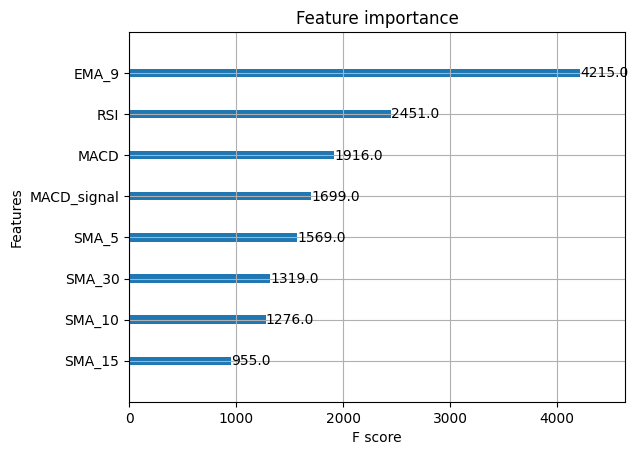

In [ ]:
plot_importance(model)

In [ ]:
visualize(df, y_pred_svr, y_test)

# LSTM

## Model

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(200))
model.add(Dense(1))

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size = 16, epochs = 20, validation_data = (X_valid, y_valid))

y_pred_lstm = model.predict(X_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 200)               13000     
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 129,169
Trainable params: 129,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
46/46 [==============================] - 10s 22ms/step - loss: 12403.7412 - val_loss: 3196.6980
Epoch 2/20
46/46 [==============================] - 0s 7ms/step - loss: 161

## Evaluation

In [ ]:
evaluation(y_test, y_pred_lstm)

MSE = 20.745123043456466
RMSE = 4.554681442588105
MAE = 3.385866094075521
R2_Score = 0.46890901129371787
MAPE = 0.03606422886170289


## Visualize Predictions

In [ ]:
visualize(df, y_pred_lstm, y_test)

# KNN

## Model

In [ ]:
knn_model = KNeighborsRegressor(n_neighbors=3)

knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

## Evaluation

In [ ]:
evaluation(y_test, y_pred_knn)

MSE = 39.387357083255424
RMSE = 6.275934757727762
MAE = 4.395249274509804
R2_Score = -0.008346413374089812
MAPE = 0.04598169420596434


## Visualize Predictions

In [ ]:
visualize(df, y_pred_knn, y_test)

# ARIMA

## Model

In [ ]:
df['Date'] = df['Date'].astype('int64')

arima_model = ARIMA(df['Date'],order=(2,2,1))

model = arima_model.fit()

model.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Date   No. Observations:                 1030
Model:                 ARIMA(2, 2, 1)   Log Likelihood              -34891.429
Date:                Thu, 04 May 2023   AIC                          69790.859
Time:                        07:46:11   BIC                          69810.600
Sample:                             0   HQIC                         69798.352
                               - 1030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3379      0.541      0.624      0.533      -0.723       1.399
ar.L2      -6.243e-05      0.000     -0.262      0.794      -0.001       0.000
ma.L1         -0.3380      0.541     -0.624      0.532      -1.399       0.723
sigma2       8.08e+27        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                 256.00   Jarque-Bera (JB):                 2.90
Prob(Q):                              0.00   Prob(JB):                         0.23
Heteroskedasticity (H):               1.08   Skew:                            -0.01
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.7e+74. Standard errors may be unstable.
"""

## Evaluation

## Visualize Predictions

# GRU

## Model

In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 200, batch_size = 5, verbose = 1)

y_pred_gru = model.predict(X_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 8, 32)             3360      
                                                                 
 gru_1 (GRU)                 (None, 8, 32)             6336      
                                                                 
 gru_2 (GRU)                 (None, 8, 32)             6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 22,401
Trainable params: 22,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
145/145 [==============================]

## Evaluation

In [ ]:
evaluation(y_test, y_pred_gru)

MSE = 1476.6854713076852
RMSE = 38.427665441810085
MAE = 37.916032230018764
R2_Score = -36.80427550717152
MAPE = 0.40709312340876336


## Visualize Predictions

In [ ]:
visualize(df, y_pred_gru, y_test)

# GradBoosting

## Model

## Evaluation

## Visualize Predictions

# LN

## Model

## Evaluation

## Visualize Predictions